In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Loading Images

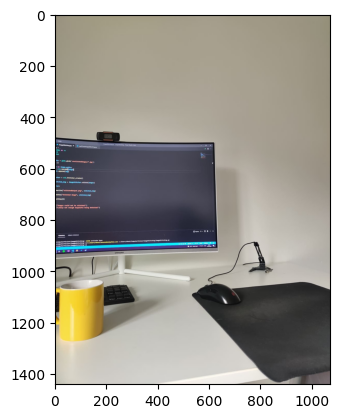

In [2]:
img1 = cv2.imread("first.jpg")
img2 = cv2.imread("second.jpg")
img3 = cv2.imread("third.jpg")
img1 = cv2.cvtColor(img1 , cv2.COLOR_BGR2RGB)
plt.imshow(img1)

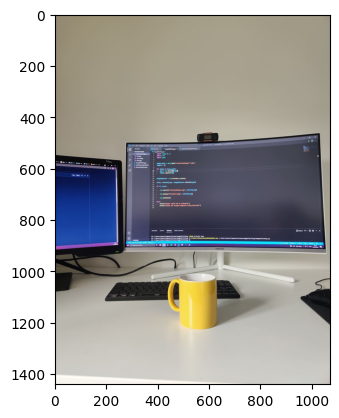

In [3]:
img2 = cv2.cvtColor(img2 , cv2.COLOR_BGR2RGB)
plt.imshow(img2)

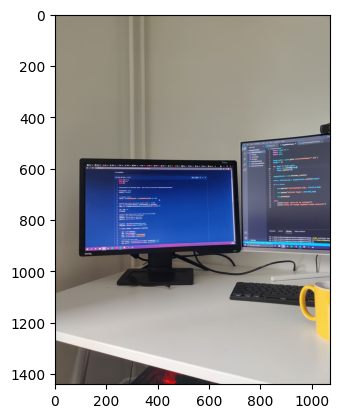

In [4]:
img3 = cv2.cvtColor(img3 , cv2.COLOR_BGR2RGB)
plt.imshow(img3)

In [5]:
sift = cv2.SIFT_create()
bf = cv2.BFMatcher(cv2.NORM_L1 , crossCheck = False)

Genrating keypoints and performing raw matching

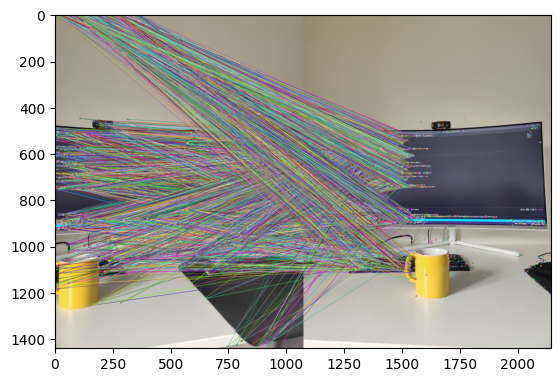

In [6]:
kp1 , des1 = sift.detectAndCompute(img1 , None)
kp2 , des2 = sift.detectAndCompute(img2 , None)
kp3 , des3 = sift.detectAndCompute(img3 , None)
matchingleft2mid = bf.knnMatch(des2 , des1 , k = 2)
matchingmid2left = bf.knnMatch(des3 , des2 , k = 2)
drawMatchleft2mid = cv2.drawMatchesKnn(img1 , kp1 , img2 , kp2 , matchingleft2mid , None)
drawMatchmid2left = cv2.drawMatchesKnn(img3 , kp3 , img2 , kp2 , matchingmid2left , None)
plt.imshow(drawMatchleft2mid)

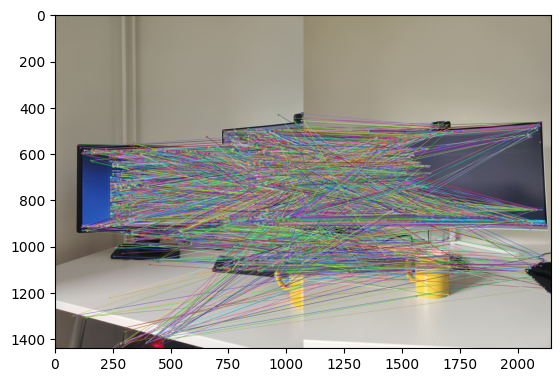

In [7]:
plt.imshow(drawMatchmid2left)

Good Matches 

[(590, 34), (550, 59), (949, 60), (718, 65), (792, 75), (380, 82), (835, 94), (1003, 95), (1002, 96), (408, 97), (37, 101), (828, 105), (69, 137), (1002, 151), (1002, 163), (627, 180), (796, 194), (917, 195), (875, 226), (876, 227), (931, 291), (435, 296), (937, 334), (409, 351), (932, 376), (931, 384), (757, 386), (575, 409), (989, 427), (575, 428), (575, 429), (757, 431), (835, 463), (835, 465), (835, 466), (37, 480), (379, 481), (835, 485), (835, 486), (835, 488), (835, 489), (835, 490), (835, 492), (835, 493), (835, 495), (845, 496), (835, 497), (835, 499), (835, 500), (835, 501), (835, 502), (835, 503), (835, 504), (835, 506), (835, 507), (835, 508), (835, 509), (835, 510), (835, 511), (128, 527), (128, 528), (128, 530), (128, 533), (88, 544), (545, 546), (87, 558), (532, 559), (117, 562), (118, 563), (164, 589), (268, 591), (164, 593), (268, 596), (269, 597), (243, 598), (706, 612), (743, 629), (758, 635), (758, 646), (88, 656), (164, 660), (89, 671), (192, 681), (166, 688), (192

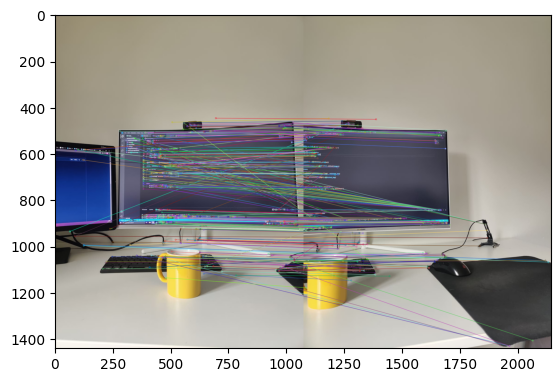

In [8]:
def GenrateGoodKeyPoints(rawMatches):
    goodKeypoints = []
    goodMatches = []
    for m1 , m2 in rawMatches:
        if m1.distance < 0.8 * m2.distance:
            goodMatches.append([m1])
            goodKeypoints.append((m1.trainIdx , m1.queryIdx))
    return goodMatches , goodKeypoints
        
left2midMatches , left2midKeypoints = GenrateGoodKeyPoints(matchingleft2mid)
mid2rightMatches , mid2rightKeypoints = GenrateGoodKeyPoints(matchingmid2left)
print(left2midKeypoints)
plt.imshow(cv2.drawMatchesKnn(img2 , kp2 , img1 , kp1 , left2midMatches , None , flags=2))

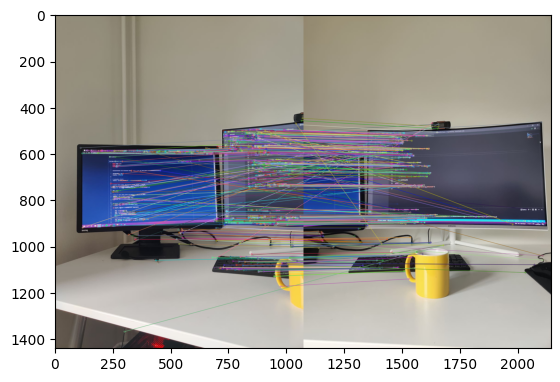

In [9]:
plt.imshow(cv2.drawMatchesKnn(img3 , kp3 , img2 , kp2, mid2rightMatches , None , flags=2))

Computing Transformation (Homography)

In [10]:
img1kp = np.array([kp1[i].pt for (i , _) in left2midKeypoints])
img21kp = np.array([kp2[i].pt for (_, i) in left2midKeypoints])
H21 , status = cv2.findHomography(np.float32(img1kp), np.float32(img21kp) , cv2.RANSAC , 5.0)
H21

array([[ 6.75978761e-01,  2.02190844e-02,  4.06360171e+02],
       [-2.32190272e-01,  8.98905392e-01,  7.06951121e+01],
       [-3.07017045e-04,  4.53365397e-06,  1.00000000e+00]])

In [11]:
img3kp = np.array([kp3[i].pt for (_ , i) in mid2rightKeypoints])
img23kp = np.array([kp2[i].pt for (i , _) in mid2rightKeypoints])
H23 , status = cv2.findHomography(np.float32(img23kp) , np.float32(img3kp) , cv2.RANSAC , 5.0)
H23

array([[ 6.79838894e-01,  2.37486453e-02,  4.56858447e+02],
       [-2.51399857e-01,  9.11653510e-01,  6.76610949e+01],
       [-3.24387394e-04,  1.23513366e-06,  1.00000000e+00]])

In [12]:
def GenratePanoroma(img1 , img2 , TransformationMatrix , maskSize):
    img2_transformed = cv2.warpPerspective(img2 , TransformationMatrix , (maskSize[0] , maskSize[1]))
    img1_transformed = np.zeros([maskSize[0] , maskSize[1] , 3] , np.uint8)
    img1_transformed[:img1.shape[0] , :img1.shape[1]] = img1
    return cv2.add(img1_transformed , img2_transformed)

In [13]:
# plt.imshow(GenratePanoroma(img3 , img2 , H23 , [img2.shape[0] + img3.shape[0] , img2.shape[1]]))

Perspective transformations of the desination keypoint images and computing panoramic view

(1440, 2144, 3)

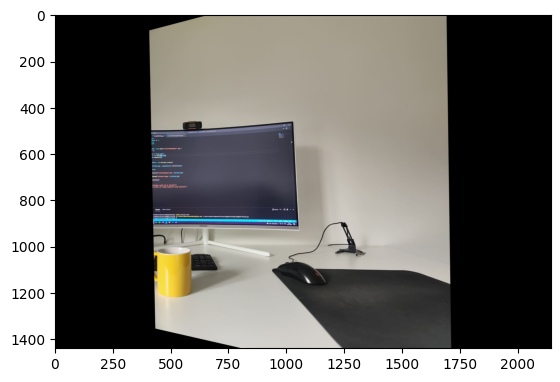

In [14]:
img1_transformed = cv2.warpPerspective(img1 , H21, (img1.shape[1] + img2.shape[1], img1.shape[0]))
plt.imshow(img1_transformed , cmap="gray")
img1_transformed.shape

In [15]:
# img2_transformed = np.zeros_like(img1_transformed)
# img2_transformed.shape

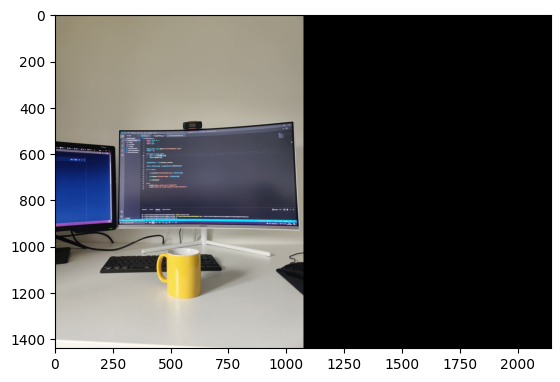

In [16]:
img2_transformed = np.zeros([img1_transformed.shape[0] , img1_transformed.shape[1] , 3] , np.uint8)
img2_transformed[:img2.shape[0],:img2.shape[1]] = img2
plt.imshow(img2_transformed , cmap="gray")

In [17]:
img2_transformed.shape

(1440, 2144, 3)

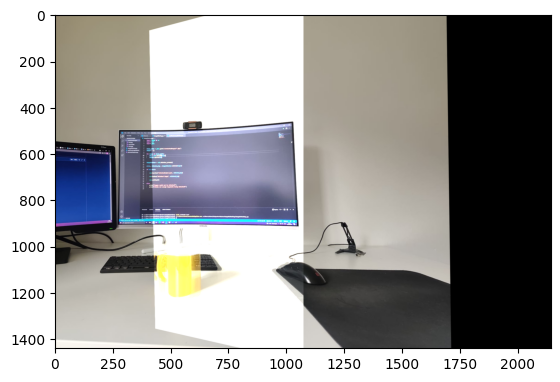

In [18]:
img_res1 = cv2.add(img2_transformed , img1_transformed)
plt.imshow(img_res1 , cmap="gray")

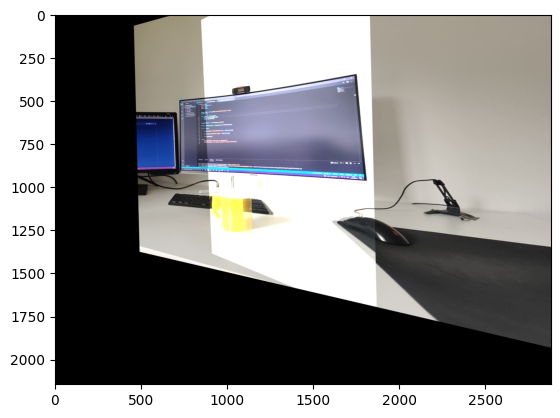

In [19]:
img_res1Transformed = cv2.warpPerspective(img_res1.copy(), H23 , (img_res1 .shape[0] + img3.shape[0], img_res1.shape[1]))
plt.imshow(img_res1Transformed)

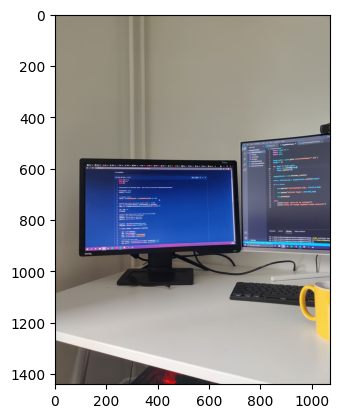

In [20]:
plt.imshow(img3)

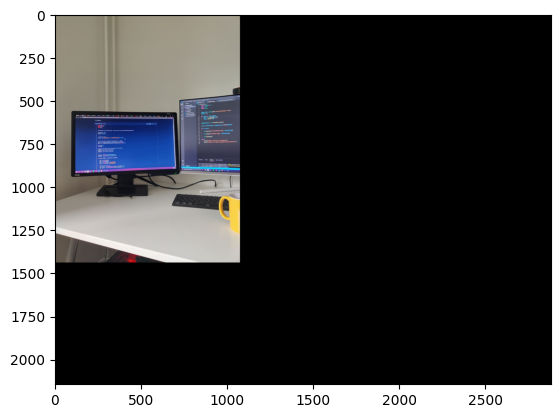

In [21]:
img3_transformed = np.zeros([img_res1Transformed.shape[0] , img_res1Transformed.shape[1] , 3], np.uint8)
img3_transformed[:img3.shape[0],:img3.shape[1]] = img3
plt.imshow(img3_transformed)

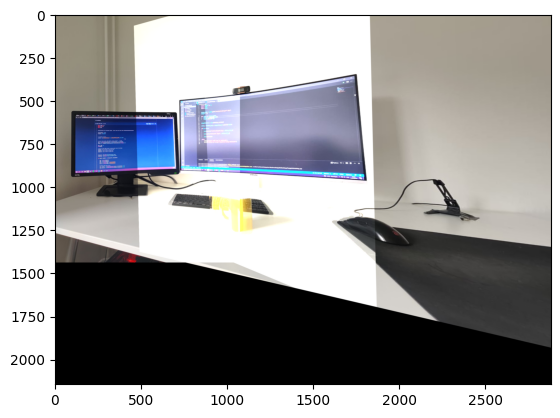

In [22]:
imgres = cv2.add(img3_transformed ,img_res1Transformed)
plt.imshow(imgres)